# Data Insights to Drive Sales: A Python-Powered Analysis and Strategy for Restaurant Growth


* Arunima Bollampally


# Main Objective of the Assignment

The primary objective of this analysis was to uncover actionable insights that could support efforts to maximize overall sales performance across varying time periods, menu items, and order types. Rather than evaluating order volume in isolation, the analysis aimed to explore when specific items are most frequently purchased and how customer behavior shifts throughout the day. By integrating order-level data with time-based segmentation and product-level detail, the goal was to identify recurring patterns that could guide decisions around pricing, promotional timing, and menu optimization. This data-driven approach reflects a broader strategy focused on aligning business decisions with customer preferences to drive revenue growth and operational efficiency. The analysis and findings that follow are intended to inform strategic initiatives that enhance both profitability and the customer experience.

# Section 1 - Data Import, Initialization, and Merge

In [ ]:
# PURPOSE:
# This setup block prepares the environment and loads all required datasets for analysis.
# It begins by importing key libraries (Pandas for data manipulation, Matplotlib and Seaborn for visualization).

# Then, it loads five key data sources in pickle format:
# - orders.pickle: raw order data
# - orders_7.pickle: enriched order data with readable item/restaurant names
# - restaurants.pickle: metadata about restaurant locations
# - items.pickle: item names and categories
# - summarized_orders.pickle: daily summary metrics by restaurant

# After loading, it ensures date columns are converted to datetime format for time-based queries.
# Lastly, it creates a master frequency table of all items ordered by flattening the four item columns
# (MAIN, BASE, SIDE_1, SIDE_2) and linking each item ID to its name and type using the item lookup table.
# This table (item_counts) is used in multiple queries to identify popular items and category-level trends.

# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load the datasets
orders_df = pd.read_pickle("orders.pickle")
orders_7_df = pd.read_pickle("orders_7.pickle")
restaurants_df = pd.read_pickle("restaurants.pickle")
items_df = pd.read_pickle("items.pickle")
summarized_orders_df = pd.read_pickle("summarized_orders.pickle")

# 3. Convert date columns to datetime
orders_7_df['DATETIME'] = pd.to_datetime(orders_7_df['DATETIME'], errors='coerce')
summarized_orders_df['DATE'] = pd.to_datetime(summarized_orders_df['DATE'], errors='coerce')

# 4. Flatten item columns into one list and count
item_columns = ['MAIN', 'BASE', 'SIDE_1', 'SIDE_2']
all_items = orders_7_df[item_columns].values.flatten()
item_counts = pd.Series(all_items).value_counts().dropna().reset_index()
item_counts.columns = ['ITEM_ID', 'COUNT']
item_counts = item_counts.merge(items_df, on='ITEM_ID', how='left')

# 5. Merge all relevant datasets to create a single enriched DataFrame

merged_orders = orders_7_df.copy()

# Merge the item names and item types into the orders dataset.
# We loop through each relevant item column (MAIN, BASE, SIDE_1, SIDE_2) to enrich the data.
for col in ['MAIN', 'BASE', 'SIDE_1', 'SIDE_2']:
    merged_orders = merged_orders.merge(
        items_df.rename(columns={
            'ITEM_ID': col,
            'ITEM_NAME': f'{col}_NAME',
            'ITEM_TYPE': f'{col}_TYPE'
        }),
        on=col,
        how='left')

# Merge restaurant metadata (name, address, coordinates, delivery start date, etc.)
# into the orders dataset using RESTAURANT_ID as the key.
merged_orders = merged_orders.merge(restaurants_df, on='RESTAURANT_ID', how='left')

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

## Preview of Dataset Contents

In [ ]:
# PURPOSE:
# This step provides a quick preview of the structure and content of each dataset by displaying
# both the first rows and the shape (number of rows and columns). It helps validate that the files
# were loaded correctly, column names are as expected, and the data types are appropriate.
# This exploratory check supports early detection of missing values, formatting issues, or inconsistencies
# across data sources, and gives a general sense of dataset size before continuing with analysis.

In [ ]:
print("orders_df shape:", orders_df.shape)
orders_df.head()

orders_df shape: (2387224, 10)


,ORDER_ID,DATETIME,RESTAURANT_ID,TYPE,DRINKS,COOKIES,MAIN,BASE,SIDE_1,SIDE_2
0,O1820060,2018-10-11 17:25:50,R10002,IN_STORE,1.0,2.0,NaN,NaN,NaN,NaN
1,O1011112,2018-05-31 11:35:00,R10003,IN_STORE,0.0,0.0,NaN,NaN,NaN,NaN
2,O752854,2018-04-21 18:12:57,R10001,DELIVERY,0.0,2.0,I0,I7,I15,I14
3,O2076864,2018-11-17 12:50:52,R10005,PICKUP,1.0,0.0,I0,I5,I9,I12
4,O1988898,2018-11-04 18:37:24,R10008,IN_STORE,0.0,0.0,I1,I7,I9,I9


In [ ]:
print("orders_7_df shape:", orders_7_df.shape)
orders_7_df.head()

orders_7_df shape: (2387224, 15)


,ORDER_ID,DATETIME,RESTAURANT_ID,TYPE,DRINKS,COOKIES,MAIN,BASE,SIDE_1,SIDE_2,RESTAURANT_NAME,MAIN_NAME,BASE_NAME,SIDE_1_NAME,SIDE_2_NAME
0,O1820060,2018-10-11 17:25:50,R10002,IN_STORE,1.0,2.0,NaN,NaN,NaN,NaN,Midtown,NaN,NaN,NaN,NaN
1,O1011112,2018-05-31 11:35:00,R10003,IN_STORE,0.0,0.0,NaN,NaN,NaN,NaN,Bryant Park,NaN,NaN,NaN,NaN
2,O752854,2018-04-21 18:12:57,R10001,DELIVERY,0.0,2.0,I0,I7,I15,I14,Columbia,Charred Chicken Marketbowl,Farro with Summer Vegetables,Snap Peas,Green Goddess Beans with Sesame
3,O2076864,2018-11-17 12:50:52,R10005,PICKUP,1.0,0.0,I0,I5,I9,I12,Flatiron,Charred Chicken Marketbowl,Classic Brown Rice,Jasper Hill Mac & Cheese,Cashew Kale Caesar
4,O1988898,2018-11-04 18:37:24,R10008,IN_STORE,0.0,0.0,I1,I7,I9,I9,Williamsburg,Spicy Meatballs Marketbowl,Farro with Summer Vegetables,Jasper Hill Mac & Cheese,Jasper Hill Mac & Cheese


In [ ]:
print("restaurants_df shape:", restaurants_df.shape)
restaurants_df.head()

restaurants_df shape: (8, 7)


,RESTAURANT_ID,NAME,ADDRESS,LAT,LONG,OPENING_DATE,DELIVERY_START
0,R10001,Columbia,"2884 Broadway, New York, NY 10025",40.811470,-73.961230,8/9/2014,2017-01-01
1,R10002,Midtown,"1379 6th Ave, New York, NY 10019",40.763640,-73.977960,3/19/2013,2018-05-01
2,R10005,Flatiron,"40 W 25th St, New York, NY 10010",40.743600,-73.991070,11/14/2013,2016-03-05
3,R10008,Williamsburg,"45 S 3rd St, Brooklyn, NY 11249",40.713749,-73.965782,10/12/2015,2017-01-01
4,R10004,NYU,"109 Macdougal St, New York, NY 10012",40.729930,-74.000820,1/10/2014,2017-01-01


In [ ]:
print("items_df shape:", items_df.shape)
items_df.head()

items_df shape: (31, 3)


,ITEM_ID,ITEM_NAME,ITEM_TYPE
0,I7,Farro with Summer Vegetables,Bases
1,I39,Spindrift Lemon,Drinks
2,I5,Classic Brown Rice,Bases
3,I36,Kombucha,Drinks
4,I8,Cauliflower with Garlic and Parmesan,Market Sides


In [ ]:
print("summarized_orders_df shape:", summarized_orders_df.shape)
summarized_orders_df.head()

summarized_orders_df shape: (2806, 4)


,RESTAURANT_NAME,DATE,NUM_ORDERS,PERC_DELIVERY
0,Bryant Park,2018-01-01,373,0.0
1,Bryant Park,2018-01-02,789,0.0
2,Bryant Park,2018-01-03,818,0.0
3,Bryant Park,2018-01-04,782,0.0
4,Bryant Park,2018-01-05,719,0.0


## Merged Dataset Overview (First 10 Entries)

In [ ]:
# PURPOSE:
# This line displays the first 10 rows of the merged dataset to provide a quick visual check
# of the structure, content, and merged fields. It allows for initial verification of column
# alignment, data types, and completeness before deeper analysis is conducted.

# Display the first 10 rows of the merged dataset
merged_orders.head(10)

# Code behavior and structure informed with support from an AI language model (OpenAI, 2023).

,ORDER_ID,DATETIME,RESTAURANT_ID,TYPE,DRINKS,COOKIES,MAIN,BASE,SIDE_1,SIDE_2,...,SIDE_1_NAME_y,SIDE_1_TYPE,SIDE_2_NAME_y,SIDE_2_TYPE,NAME,ADDRESS,LAT,LONG,OPENING_DATE,DELIVERY_START
0,O1820060,2018-10-11 17:25:50,R10002,IN_STORE,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Midtown,"1379 6th Ave, New York, NY 10019",40.763640,-73.977960,3/19/2013,2018-05-01
1,O1011112,2018-05-31 11:35:00,R10003,IN_STORE,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Bryant Park,"70 W 40th St, New York, NY 10018",40.752911,-73.983498,5/21/2013,2018-05-01
2,O752854,2018-04-21 18:12:57,R10001,DELIVERY,0.0,2.0,I0,I7,I15,I14,...,Snap Peas,Market Sides,Green Goddess Beans with Sesame,Market Sides,Columbia,"2884 Broadway, New York, NY 10025",40.811470,-73.961230,8/9/2014,2017-01-01
3,O2076864,2018-11-17 12:50:52,R10005,PICKUP,1.0,0.0,I0,I5,I9,I12,...,Jasper Hill Mac & Cheese,Market Sides,Cashew Kale Caesar,Market Sides,Flatiron,"40 W 25th St, New York, NY 10010",40.743600,-73.991070,11/14/2013,2016-03-05
4,O1988898,2018-11-04 18:37:24,R10008,IN_STORE,0.0,0.0,I1,I7,I9,I9,...,Jasper Hill Mac & Cheese,Market Sides,Jasper Hill Mac & Cheese,Market Sides,Williamsburg,"45 S 3rd St, Brooklyn, NY 11249",40.713749,-73.965782,10/12/2015,2017-01-01
5,O1026484,2018-06-02 14:32:53,R10008,DELIVERY,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Williamsburg,"45 S 3rd St, Brooklyn, NY 11249",40.713749,-73.965782,10/12/2015,2017-01-01
6,O1878199,2018-10-19 19:55:09,R10008,PICKUP,0.0,0.0,I3,I6,I10,I12,...,Roasted Sweet Potatoes,Market Sides,Cashew Kale Caesar,Market Sides,Williamsburg,"45 S 3rd St, Brooklyn, NY 11249",40.713749,-73.965782,10/12/2015,2017-01-01
7,O720465,2018-04-17 12:06:05,R10003,PICKUP,0.0,0.0,I0,I6,I10,I11,...,Roasted Sweet Potatoes,Market Sides,Charred Broccoli with Lemon,Market Sides,Bryant Park,"70 W 40th St, New York, NY 10018",40.752911,-73.983498,5/21/2013,2018-05-01
8,O1514673,2018-08-24 17:27:07,R10002,DELIVERY,0.0,0.0,I3,I7,I15,I10,...,Snap Peas,Market Sides,Roasted Sweet Potatoes,Market Sides,Midtown,"1379 6th Ave, New York, NY 10019",40.763640,-73.977960,3/19/2013,2018-05-01
9,O80138,2018-01-13 19:57:46,R10006,DELIVERY,0.0,0.0,I4,I7,I9,I11,...,Jasper Hill Mac & Cheese,Market Sides,Charred Broccoli with Lemon,Market Sides,Upper East Side,"1045 Lexington Ave, New York, NY 10021",40.772010,-73.960780,5/29/2014,2017-08-02


## Null Value Treatment and Dataset Refinement

In [ ]:
# PURPOSE:
# This step checks for null values to assess data completeness and identify potential issues
# before analysis. Detecting NaNs helps ensure that missing data is properly handled
# without introducing bias.

# Check null values across all datasets

for name, df in {
    'orders_df': orders_df,
    'orders_7_df': orders_7_df,
    'items_df': items_df,
    'restaurants_df': restaurants_df,
    'summarized_orders_df': summarized_orders_df,
    'merged_orders': merged_orders
}.items():
    print(f"\nNull values in {name}:")
    print(df.isnull().sum())

# NOTE:
# NaNs are intentionally left as-is because replacing them with 0s could misrepresent the data—
# for example, a missing value does not always mean zero (e.g., an unrecorded item is not the same
# as an item that wasn’t ordered). Since the analysis and visualizations already functioned correctly,
# preserving NaNs maintains the accuracy and integrity of the results.

# Code behavior and structure informed with support from an AI language model (OpenAI, 2023).


Null values in orders_df:
ORDER_ID              0
DATETIME              0
RESTAURANT_ID         0
TYPE                  0
DRINKS                0
COOKIES               0
MAIN             111585
BASE             111585
SIDE_1           111585
SIDE_2           111585
dtype: int64

Null values in orders_7_df:
ORDER_ID                0
DATETIME                0
RESTAURANT_ID           0
TYPE                    0
DRINKS                  0
COOKIES                 0
MAIN               111585
BASE               111585
SIDE_1             111585
SIDE_2             111585
RESTAURANT_NAME         0
MAIN_NAME          111585
BASE_NAME          111585
SIDE_1_NAME        111585
SIDE_2_NAME        111585
dtype: int64

Null values in items_df:
ITEM_ID      0
ITEM_NAME    0
ITEM_TYPE    0
dtype: int64

Null values in restaurants_df:
RESTAURANT_ID     0
NAME              0
ADDRESS           0
LAT               0
LONG              0
OPENING_DATE      0
DELIVERY_START    0
dtype: int64

Null values in sum

# Section 2 - Current Scenario

## Total Orders by Restaurant

In [ ]:
# PURPOSE:
# This code calculates the total number of orders placed at each restaurant by counting
# the number of times each restaurant appears in the full 'orders_7_df' dataset.

# Query 1: Total Orders by Restaurant
total_orders_by_restaurant = orders_7_df['RESTAURANT_NAME'].value_counts().reset_index()
total_orders_by_restaurant.columns = ['RESTAURANT_NAME', 'TOTAL_ORDERS']

# Display table
print(total_orders_by_restaurant)

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

   RESTAURANT_NAME  TOTAL_ORDERS
0              NYU        430860
1          Midtown        325265
2     Williamsburg        314674
3         Flatiron        281983
4  Upper West Side        281186
5  Upper East Side        275001
6         Columbia        250810
7      Bryant Park        227445


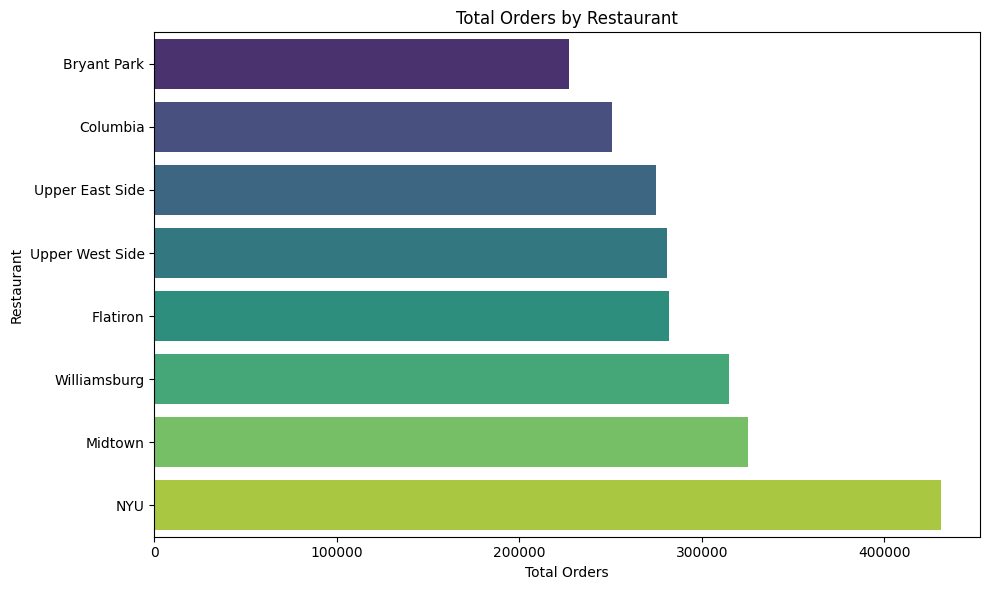

In [ ]:
# PURPOSE:
# This chart visually presents the insights derived from the previous code query.

import matplotlib.pyplot as plt
import seaborn as sns

# Sort for better visual order
sorted_orders = total_orders_by_restaurant.sort_values(by='TOTAL_ORDERS', ascending=True)

# Plot using hue to comply with future Seaborn versions
plt.figure(figsize=(10, 6))
sns.barplot(
    x='TOTAL_ORDERS',
    y='RESTAURANT_NAME',
    data=sorted_orders,
    hue='RESTAURANT_NAME',       # Added hue to match palette use
    palette='viridis',
    legend=False                 # Hide redundant legend
)

plt.title('Total Orders by Restaurant')
plt.xlabel('Total Orders')
plt.ylabel('Restaurant')
plt.tight_layout()
plt.savefig('total_orders_by_restaurant_barh.png', dpi=300)
plt.show()

# FINDINGS:
# In the full dataset, the restaurant with the highest total number of orders is **NYU**,
# followed by **Midtown**, **Williamsburg**, and **Flatiron**. This ranking helps identify
# top-performing locations. These insights can guide strategic decisions related to resource allocation,
# promotional targeting, or identifying operational best practices from high-volume stores.

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

## Average Daily Orders by Restaurant

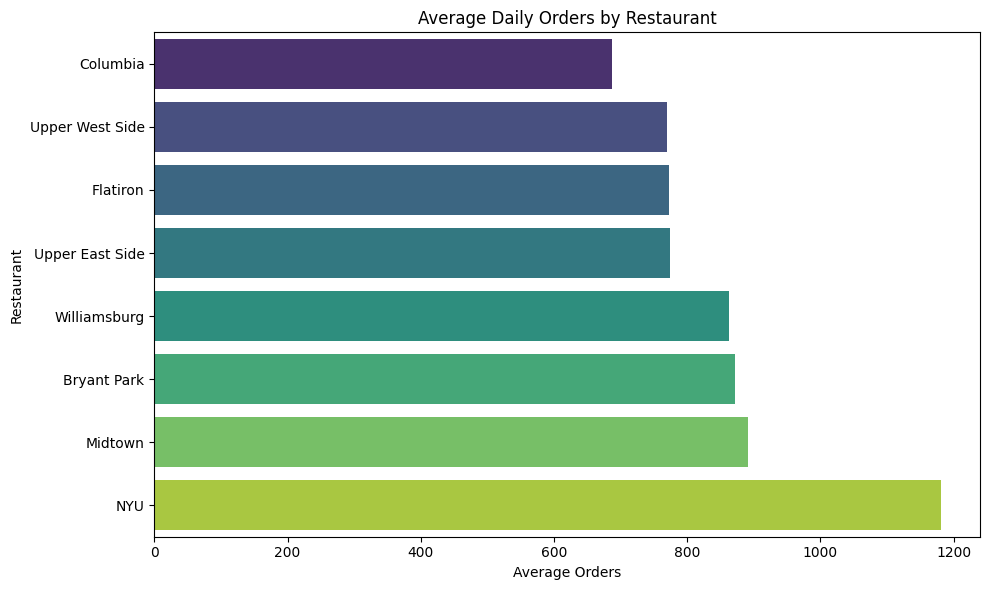

In [ ]:
# PURPOSE:
# This code computes the average number of daily orders per restaurant using the
# 'summarized_orders_df' DataFrame, which contains pre-aggregated daily metrics.

import matplotlib.pyplot as plt
import seaborn as sns

# Query 2: Average Daily Orders by Restaurant
avg_daily_orders = summarized_orders_df.groupby('RESTAURANT_NAME')['NUM_ORDERS'].mean().reset_index()
avg_daily_orders.columns = ['RESTAURANT_NAME', 'AVG_DAILY_ORDERS']

# Sort for better visual order
sorted_avg_daily_orders = avg_daily_orders.sort_values(by='AVG_DAILY_ORDERS', ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    x='AVG_DAILY_ORDERS',
    y='RESTAURANT_NAME',
    data=sorted_avg_daily_orders,
    hue='RESTAURANT_NAME',       # Added hue to match palette use
    palette='viridis',
    legend=False                 # Hide redundant legend
)
plt.title('Average Daily Orders by Restaurant')
plt.xlabel('Average Orders')
plt.ylabel('Restaurant')
plt.tight_layout()
plt.savefig('avg_daily_orders_by_restaurant.png')  # Saves the chart
plt.show()

# FINDINGS:
# When examining daily performance, **NYU** also stands out as the leader with an average of
# over 1,180 orders per day. Other high-performing locations include **Midtown** and **Bryant Park**.
# This daily average metric is useful for planning staffing, operations, and forecasting demand,
# as it reflects consistent performance over time rather than a one-time peak.

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

## Distribution of Item Types Ordered

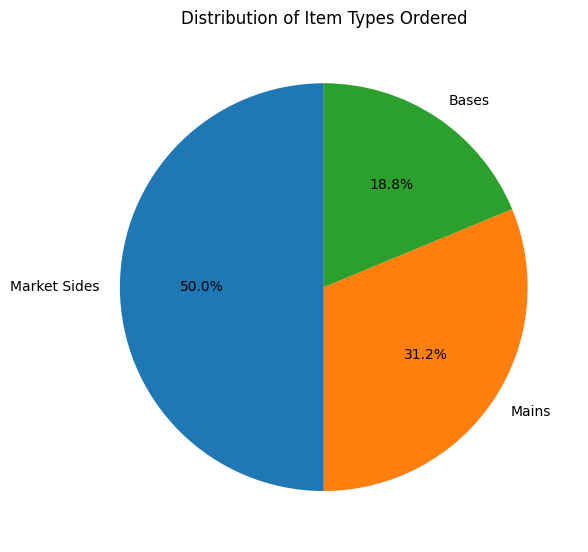

In [ ]:
# PURPOSE:
# This code aggregates the types of food items ordered (Mains, Bases, Market Sides)
# across all relevant item columns ('MAIN', 'BASE', 'SIDE_1', 'SIDE_2') in the full dataset.

# Query 3: Distribution of Item Types Ordered
item_columns = ['MAIN', 'BASE', 'SIDE_1', 'SIDE_2']
all_items = orders_7_df[item_columns].values.flatten()

# Count frequency of each item ID
item_counts = pd.Series(all_items).value_counts().dropna().reset_index()
item_counts.columns = ['ITEM_ID', 'COUNT']

# Merge with item names/types
item_counts = item_counts.merge(items_df, on='ITEM_ID', how='left')
item_type_distribution = item_counts['ITEM_TYPE'].value_counts()

# Plotting
plt.figure(figsize=(6, 6))
item_type_distribution.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Item Types Ordered')
plt.ylabel('')
plt.tight_layout()
plt.savefig('item_type_distribution_pie.png')
plt.show()

# FINDINGS:
# The most commonly ordered category is **Market Sides**, followed by **Mains** and **Bases**.
# This suggests that customers frequently build meals around customizable or add-on items.
# The business could explore offering bundled combos or promoting top sides for upselling.

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

## Order Type Distribution by Restaurant

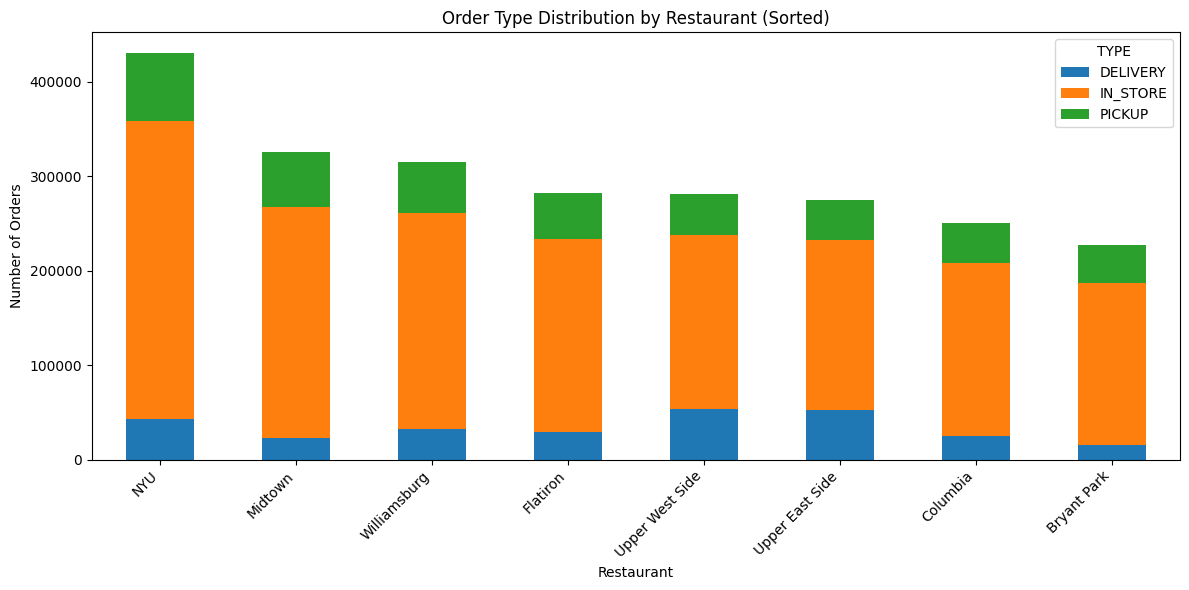

In [ ]:
# PURPOSE:
# This code analyzes how customers interact with each restaurant by breaking down order types:
# DELIVERY, IN_STORE, and PICKUP. It uses groupby to count the number of each type by location,
# and presents the results in a stacked bar chart.

# Query 4: Order Type Distribution by Restaurant
order_types = orders_7_df.groupby(['RESTAURANT_NAME', 'TYPE']).size().unstack(fill_value=0)
order_types_sorted = order_types.sum(axis=1).sort_values(ascending=False).index
order_types = order_types.loc[order_types_sorted]

# Plotting
order_types.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Order Type Distribution by Restaurant (Sorted)')
plt.xlabel('Restaurant')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('order_type_by_restaurant_sorted.png')
plt.show()

# FINDINGS:
# The chart reveals that most restaurants show a **balanced mix of order types**.
# Notably, **NYU** handles a very high volume of orders, primarily **IN_STORE**, but also has
# substantial numbers of **DELIVERY** and **PICKUP** orders. This indicates high traffic and
# operational diversity at that location.
# Locations like **Flatiron** and **Midtown** also display healthy distributions across all types.
# These insights are valuable for tailoring service models, such as staffing for walk-ins,
# optimizing delivery logistics, or enhancing pickup systems based on local preferences.

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

## Monthly Trend of Order Types Across All Restaurants

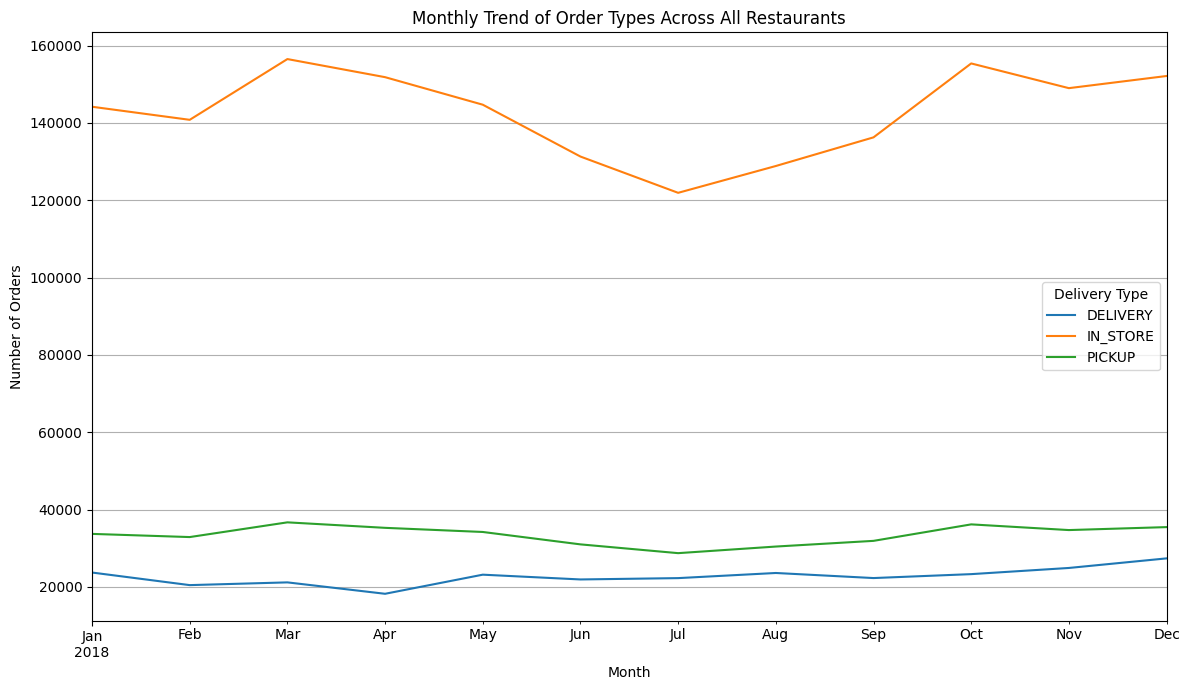

In [ ]:
# PURPOSE:
# This query analyzes how the volume of each order type (DELIVERY, IN_STORE, PICKUP) changes over time.
# It groups the data by calendar month and order type, then plots a line chart to show trends.
# The goal is to identify patterns or shifts in customer behavior across months.

# Group by month and delivery type, then count orders
# We use orders_7_df, as it contains the 'TYPE' column
monthly_delivery_counts = orders_7_df.groupby([pd.Grouper(key='DATETIME', freq='ME'), 'TYPE']).size().unstack(fill_value=0)

# Plot the data
plt.figure(figsize=(12, 7))
monthly_delivery_counts.plot(kind='line', ax=plt.gca()) # Plotting multiple lines

plt.title('Monthly Trend of Order Types Across All Restaurants')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.legend(title='Delivery Type')
plt.tight_layout()
plt.show()

# FINDINGS:
# The chart reveals several key insights:
# - IN_STORE orders are consistently the dominant channel across months.
# - DELIVERY and PICKUP volumes remain relatively stable but much lower in comparison.
# - There are visible seasonal or operational fluctuations, such as slight dips or surges at certain times.
# These patterns can inform monthly staffing strategies, promotional timing, and channel-specific investments.
# For example, if DELIVERY or PICKUP grows in certain months, marketing could support those peaks.

# Code structure and visualization strategy adapted with assistance from an AI language model (OpenAI, 2023).

## Order Count by Time of the Day

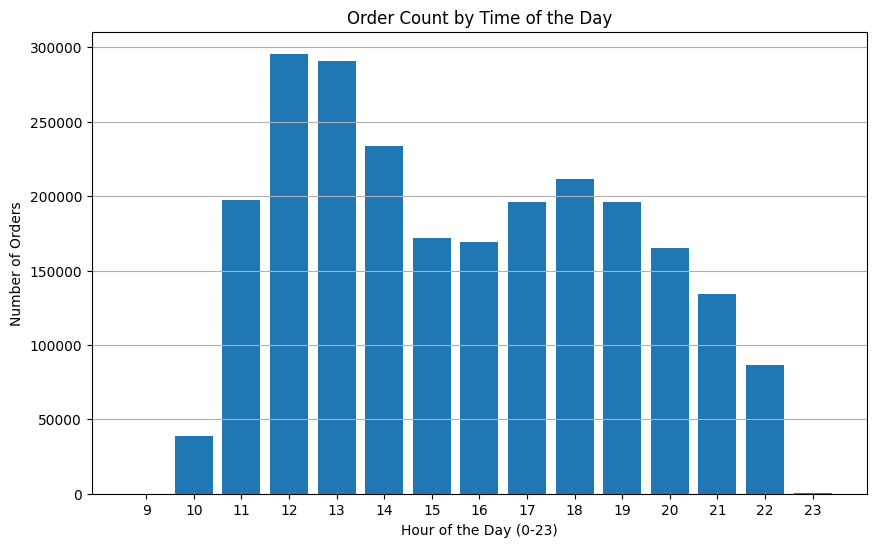

In [ ]:
# PURPOSE:
# This query analyzes the distribution of order volume across different hours of the day.
# By extracting the hour from the order timestamp and grouping by it, we can determine peak ordering periods.
# The resulting bar chart helps visualize when customers are most actively placing orders.

# Give order count by time of the day
# Extract the hour from the DATETIME column
orders_7_df['HOUR'] = orders_7_df['DATETIME'].dt.hour

# Group by hour and count the number of orders
orders_by_hour = orders_7_df.groupby('HOUR').size().reset_index(name='order_count')

plt.figure(figsize=(10, 6))
plt.bar(orders_by_hour['HOUR'], orders_by_hour['order_count'])
plt.title('Order Count by Time of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Orders')
plt.xticks(orders_by_hour['HOUR']) # Ensure all hours are shown on the x-axis
plt.grid(axis='y')
plt.show()

# FINDINGS:
# The data shows a clear peak in orders between 11:00 AM and 1:00 PM, which aligns with the lunch rush.
# A secondary increase appears between 5:00 PM and 7:00 PM, suggesting a dinner-time demand window.
# These insights are operationally important for shift planning, kitchen prep, and optimizing promotional timing
# around lunch and dinner periods.

# Code structure and analysis logic adapted with assistance from an AI language model (OpenAI, 2023).

## Order Volume by Day of the Week

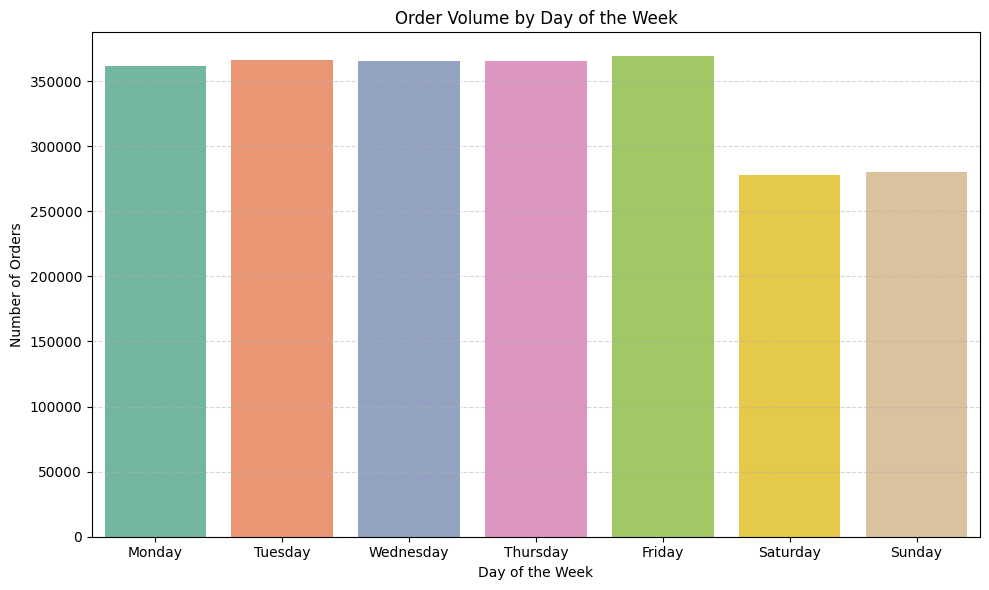

In [ ]:
# PURPOSE:
# This chart shows the total number of orders placed on each day of the week.
# It is useful for identifying which weekdays are busiest and supporting staffing,
# prep, and promotional scheduling accordingly.

# Extract the day of the week
orders_7_df['DAY_OF_WEEK'] = orders_7_df['DATETIME'].dt.day_name()

# Group and sort by weekday order
orders_by_day = orders_7_df['DAY_OF_WEEK'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()
orders_by_day.columns = ['DAY', 'ORDER_COUNT']

# Plot using hue to avoid future deprecation
plt.figure(figsize=(10, 6))
sns.barplot(
    x='DAY',
    y='ORDER_COUNT',
    hue='DAY',                # Assign x-axis to hue
    data=orders_by_day,
    palette='Set2',
    legend=False              # Turn off redundant legend
)

plt.title('Order Volume by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# FINDINGS:
# The chart shows that order volume is consistently high Monday through Friday,
# with Friday having the highest total number of orders overall.
# A noticeable drop occurs on the weekend, with both Saturday and Sunday showing
# significantly lower volumes compared to weekdays.
# This pattern suggests that customer engagement is strongest during the workweek,
# possibly due to routine meal planning or workplace lunch behavior.
# Weekend operations may require less staffing, while weekday promotions and prep
# should be prioritized to meet higher demand.

# Code structure and analysis adapted with assistance from an AI language model (OpenAI, 2023).

# Section 3 – Exploratory Analysis

## Bottom 10 Least Ordered Items Overall

In [ ]:
# PURPOSE:
# This query identifies the bottom 10 least frequently ordered menu items across all order types and item categories
# (main, base, side_1, and side_2). By reshaping the data and counting occurrences of each ITEM_ID,
# the query reveals which items are underperforming in terms of customer demand.
# This analysis is useful for identifying potential items to remove, improve, or promote differently.

# Define the columns that contain item IDs
items_cols = ['MAIN', 'BASE', 'SIDE_1', 'SIDE_2']

# Flatten the specified item columns and drop rows with missing values
all_items = orders_7_df[items_cols].melt(value_name='ITEM_ID').dropna()

# Count the total occurrences of each ITEM_ID and reset the index
item_totals = all_items['ITEM_ID'].value_counts().reset_index()

# Rename columns for clarity
item_totals.columns = ['ITEM_ID', 'TOTAL_ORDERS']

# Merge with the items_df DataFrame to get ITEM_NAME
item_totals = item_totals.merge(items_df[['ITEM_ID', 'ITEM_NAME']], on='ITEM_ID', how='left')

# Print the bottom 10 least ordered items
print("Bottom 10 Least Ordered Items:\n", item_totals.tail(10))

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

Bottom 10 Least Ordered Items:
    ITEM_ID  TOTAL_ORDERS                               ITEM_NAME
6       I8        628136    Cauliflower with Garlic and Parmesan
7       I1        590685              Spicy Meatballs Marketbowl
8       I5        508513                      Classic Brown Rice
9      I11        460190             Charred Broccoli with Lemon
10     I12        412992                      Cashew Kale Caesar
11      I9        404399                Jasper Hill Mac & Cheese
12     I13        353950                     Blistered Shishitos
13     I14        309898         Green Goddess Beans with Sesame
14      I2        183158         Grilled Organic Tofu Marketbowl
15      I4        114447  Roasted Wild Alaskan Salmon Marketbowl


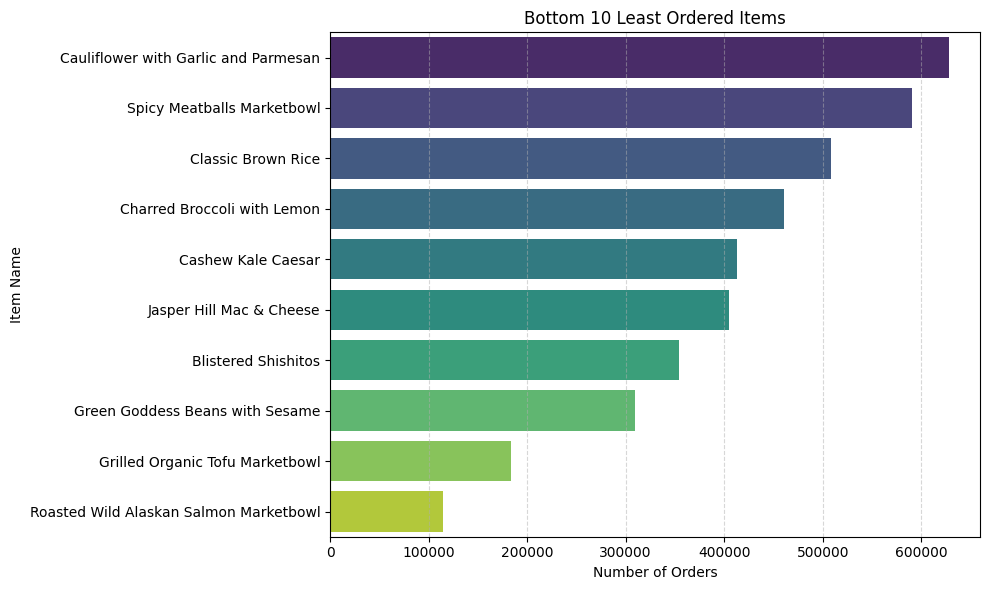

In [ ]:
# PURPOSE:
# This chart visually presents the insights derived from the previous code query.

import matplotlib.pyplot as plt

# Plotting for Bottom 10 Least Ordered
plt.figure(figsize=(10, 6))
sns.barplot(
    x='TOTAL_ORDERS',
    y='ITEM_NAME',
    hue='ITEM_NAME', # Assign y-axis to hue
    data=item_totals.tail(10),
    palette='viridis',
    legend=False              # Turn off redundant legend
)
plt.title('Bottom 10 Least Ordered Items')
plt.xlabel('Number of Orders')
plt.ylabel('Item Name')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# FINDINGS:
# The chart shows that items like Roasted Wild Alaskan Salmon Marketbowl and Grilled Organic Tofu Marketbowl
# have the lowest total order counts across all item categories, suggesting weak customer demand.
# Several side or base components such as Green Goddess Beans with Sesame, Blistered Shishitos, and
# Charred Broccoli with Lemon also rank among the least ordered.
# Surprisingly, Spicy Meatballs Marketbowl — a top seller in other queries — appears here as well,
# which suggests it may not be frequently chosen as a BASE, SIDE_1, or SIDE_2, but rather primarily as a MAIN.
# These insights can inform product optimization, menu simplification, or promotional adjustments
# to improve performance of these low-demand items.

## Menu Items Ordered by Time Slot and Order Type

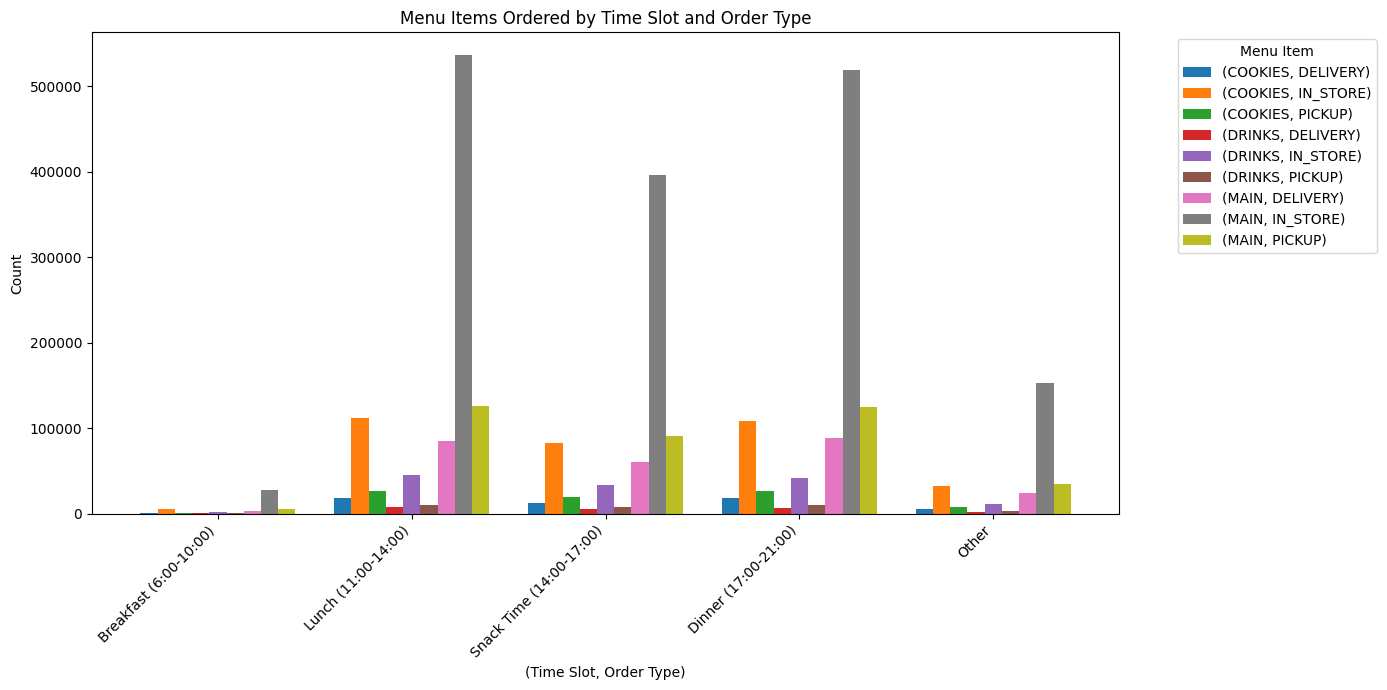

In [ ]:
# PURPOSE:
# This code analyzes customer ordering behavior by examining how frequently DRINKS, COOKIES, and MAIN items
# are ordered across different time slots (e.g., Breakfast, Lunch) and order types (DELIVERY, IN_STORE, PICKUP).
# The result is a multi-category bar chart that visualizes the volume of each item type within each
# (Time Slot, Order Type) combination, helping identify peak periods and preferences per channel.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the DATETIME column is in datetime format
if not pd.api.types.is_datetime64_any_dtype(orders_7_df['DATETIME']):
    orders_7_df['DATETIME'] = pd.to_datetime(orders_7_df['DATETIME'])

# Define time slot buckets based on hour
def get_time_slot(hour):
    if 6 <= hour < 11:
        return 'Breakfast (6:00-10:00)'
    elif 11 <= hour < 14:
        return 'Lunch (11:00-14:00)'
    elif 14 <= hour < 17:
        return 'Snack Time (14:00-17:00)'
    elif 17 <= hour < 21:
        return 'Dinner (17:00-21:00)'
    else:
        return 'Other'

# Assign time slots
orders_7_df['Time Slot'] = orders_7_df['DATETIME'].dt.hour.apply(get_time_slot)

# Aggregation functions for counting non-zero or non-null items
agg_funcs = {
    'DRINKS': lambda x: (x > 0).sum(),
    'COOKIES': lambda x: (x > 0).sum(),
    'MAIN': lambda x: x.replace(['NaN', 'nan'], np.nan).notnull().sum()
}

# Group and aggregate by time slot and order type
df_time_grouped = orders_7_df.groupby(['Time Slot', 'TYPE']).agg(agg_funcs).reset_index()

# Pivot the data for easier plotting
df_pivot_time = df_time_grouped.pivot_table(
    index=['Time Slot', 'TYPE'],
    values=['DRINKS', 'COOKIES', 'MAIN'],
    aggfunc='sum'
)

# Reorder time slots
time_slot_order = [
    'Breakfast (6:00-10:00)',
    'Lunch (11:00-14:00)',
    'Snack Time (14:00-17:00)',
    'Dinner (17:00-21:00)',
    'Other'
]
df_pivot_time = df_pivot_time.reindex(time_slot_order, level='Time Slot')

# Add total row for reference (excluded from plot)
total_row = df_pivot_time.sum()
df_pivot_time.loc[('Total', ''), :] = total_row

# --------- BAR CHART: Count of Menu Items by Time Slot and Order Type ---------

# Exclude the total row for plotting
df_pivot_time_for_plot = df_pivot_time.drop(('Total', ''))

# Plot count data
df_pivot_time_for_plot.unstack().plot(kind='bar', figsize=(14, 7), width=0.8)
plt.title('Menu Items Ordered by Time Slot and Order Type')
plt.xlabel('(Time Slot, Order Type)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Menu Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# FINDINGS:
# The chart reveals that in-store orders dominate item counts across all time slots.
# The highest volume of main items occurs during the Snack Time and Dinner periods for IN_STORE orders.
# DRINKS and COOKIES are most frequently ordered in-store during Lunch and Dinner,
# while DELIVERY and PICKUP channels consistently show lower volumes across all item types and times.
# Breakfast and 'Other' time slots show relatively low order activity in all channels,
# suggesting limited demand during off-peak hours.
# This insight can support menu tailoring, staffing levels, and promotional timing
# based on when and how customers interact with specific item types.

# Code structure and visualization logic adapted with assistance from an AI language model (OpenAI, 2023).

## Order Volume by Hour and Day of Week

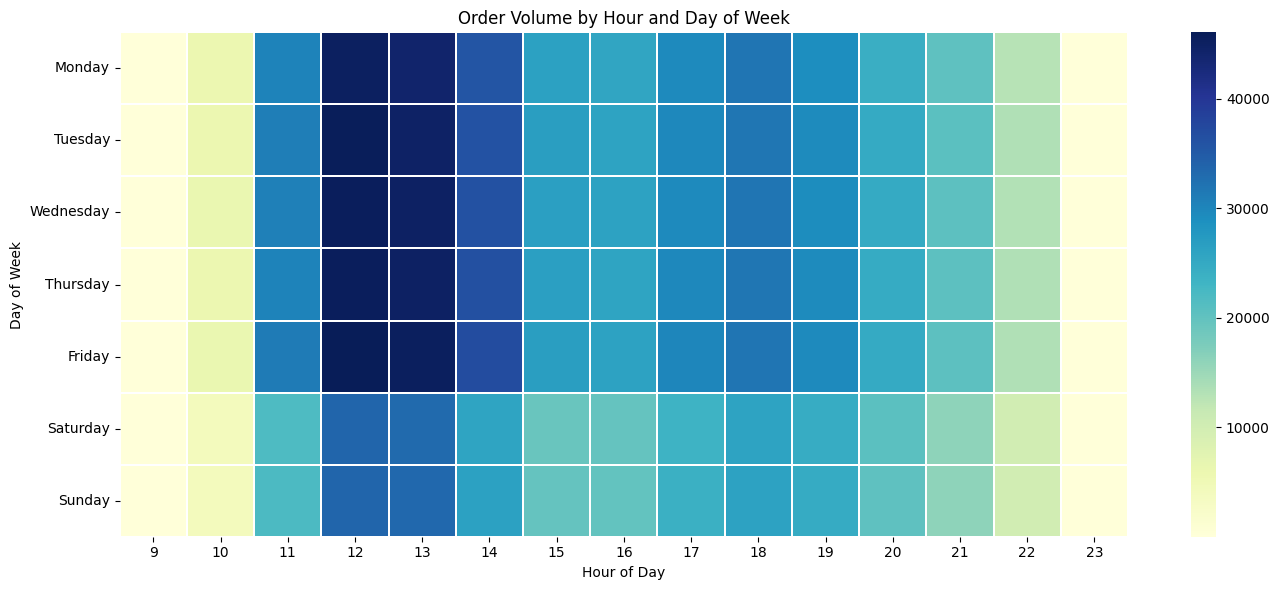

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# PURPOSE:
# This query generates a heatmap showing the distribution of order volume across
# days of the week and hours of the day. It helps identify peak demand times across the full dataset.

# Extract day of week and hour
merged_orders['DAY_OF_WEEK'] = merged_orders['DATETIME'].dt.day_name()
merged_orders['HOUR'] = merged_orders['DATETIME'].dt.hour

# Create pivot table: count of orders by day and hour
heatmap_data = merged_orders.pivot_table(
    index='DAY_OF_WEEK',
    columns='HOUR',
    values='ORDER_ID',
    aggfunc='count'
).fillna(0)

# Reorder days for clarity
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.3)
plt.title('Order Volume by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

# FINDINGS:
# The heatmap reveals clear patterns of customer behavior. For instance, late afternoons
# on weekdays may show high activity across all channels, while weekends may have different peaks.
# These insights are valuable for staffing, prep scheduling, and timing promotions.

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

## Top 5 Mains by Order Type

In [ ]:
# PURPOSE:
# This query identifies the five most frequently ordered MAIN items for each type of order:
# IN_STORE, DELIVERY, and PICKUP. It groups the orders by order type and main item name,
# counts how many times each item appears, and selects the top five items per order channel.

top_mains_by_type = (
    merged_orders.groupby(['TYPE', 'MAIN_NAME_x'])['ORDER_ID']
    .count()
    .reset_index()
    .sort_values(['TYPE', 'ORDER_ID'], ascending=[True, False])
    .groupby('TYPE')
    .head(5)
)

print(top_mains_by_type)

# FINDINGS:
# This analysis helps the business understand which MAIN dishes are most successful depending on
# how the customer orders. For example, some bowls may sell better in-store due to presentation,
# while others may travel better for delivery or are preferred for pickup.
# This insight can inform menu design, optimize packaging, and guide platform-specific promotions.

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

        TYPE                             MAIN_NAME_x  ORDER_ID
0   DELIVERY              Charred Chicken Marketbowl     79212
2   DELIVERY         Herb Roasted Chicken Marketbowl     79051
4   DELIVERY              Spicy Meatballs Marketbowl     67570
1   DELIVERY         Grilled Organic Tofu Marketbowl     20944
3   DELIVERY  Roasted Wild Alaskan Salmon Marketbowl     13195
5   IN_STORE              Charred Chicken Marketbowl    497761
7   IN_STORE         Herb Roasted Chicken Marketbowl    497755
9   IN_STORE              Spicy Meatballs Marketbowl    423738
6   IN_STORE         Grilled Organic Tofu Marketbowl    131433
8   IN_STORE  Roasted Wild Alaskan Salmon Marketbowl     82112
10    PICKUP              Charred Chicken Marketbowl    116874
12    PICKUP         Herb Roasted Chicken Marketbowl    116696
14    PICKUP              Spicy Meatballs Marketbowl     99377
11    PICKUP         Grilled Organic Tofu Marketbowl     30781
13    PICKUP  Roasted Wild Alaskan Salmon Marketbowl   

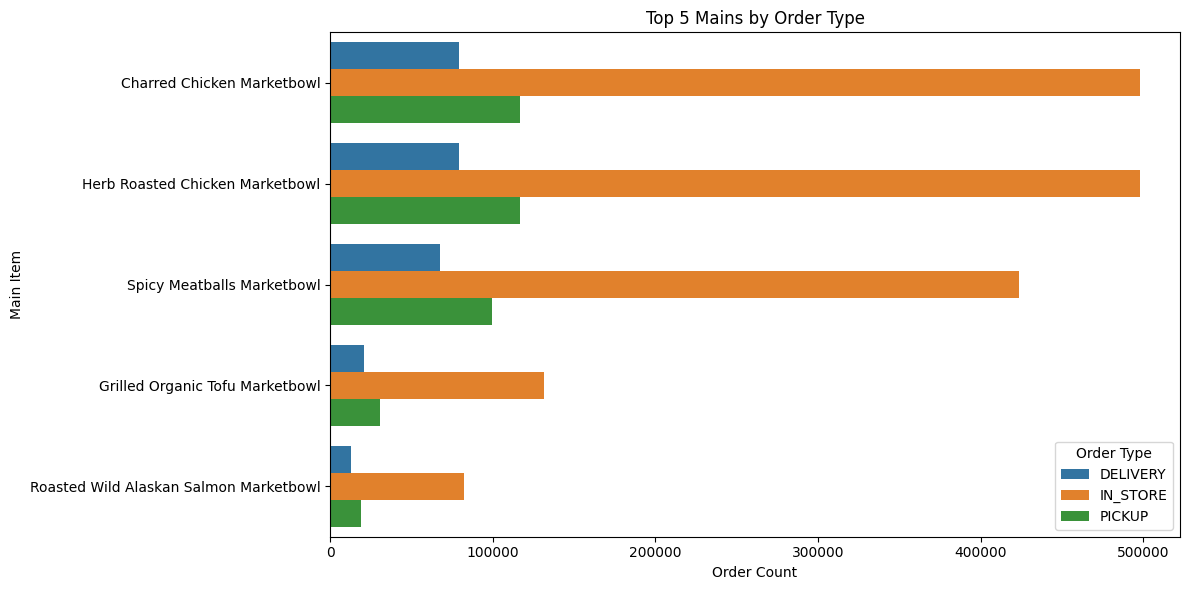

In [ ]:
# PURPOSE:
# This chart visually presents the insights derived from the previous code query.

import seaborn as sns

# Make sure MAIN_NAME_x exists
top_mains_by_type = (
    merged_orders.groupby(['TYPE', 'MAIN_NAME_x'])['ORDER_ID']
    .count()
    .reset_index()
    .sort_values(['TYPE', 'ORDER_ID'], ascending=[True, False])
    .groupby('TYPE')
    .head(5)
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='ORDER_ID', y='MAIN_NAME_x', hue='TYPE', data=top_mains_by_type)
plt.title('Top 5 Mains by Order Type')
plt.xlabel('Order Count')
plt.ylabel('Main Item')
plt.legend(title='Order Type')
plt.tight_layout()
plt.show()

# FINDINGS:
# The chart shows that IN_STORE is the dominant order type across all top 5 main items,
# with Charred Chicken Marketbowl and Herb Roasted Chicken Marketbowl leading in total volume.
# While DELIVERY and PICKUP orders contribute to overall sales, they remain significantly lower
# for each item compared to IN_STORE orders. Spicy Meatballs Marketbowl ranks third overall but
# maintains strong PICKUP performance, suggesting it may be a popular grab-and-go option.
# The data suggests that customers strongly prefer ordering mains in-store, and menu strategy,
# kitchen layout, and staffing should continue to prioritize high in-store main volume.

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

## Top 5 Most Ordered Items

In [ ]:
# PURPOSE:
# This code identifies the five most frequently ordered individual items (food or drink)
# across all restaurants using item IDs merged with names from the item lookup table.

# Query 5: Top 5 Items Ordered Overall
top_items = item_counts[['ITEM_NAME', 'COUNT']]\
    .groupby('ITEM_NAME')\
    .sum()\
    .sort_values(by='COUNT', ascending=False)\
    .head(5)\
    .reset_index()

# Display table
print(top_items)

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

                      ITEM_NAME   COUNT
0        Roasted Sweet Potatoes  995263
1                     Snap Peas  986450
2         Farm Greens with Mint  918077
3  Farro with Summer Vegetables  849049
4    Charred Chicken Marketbowl  693847


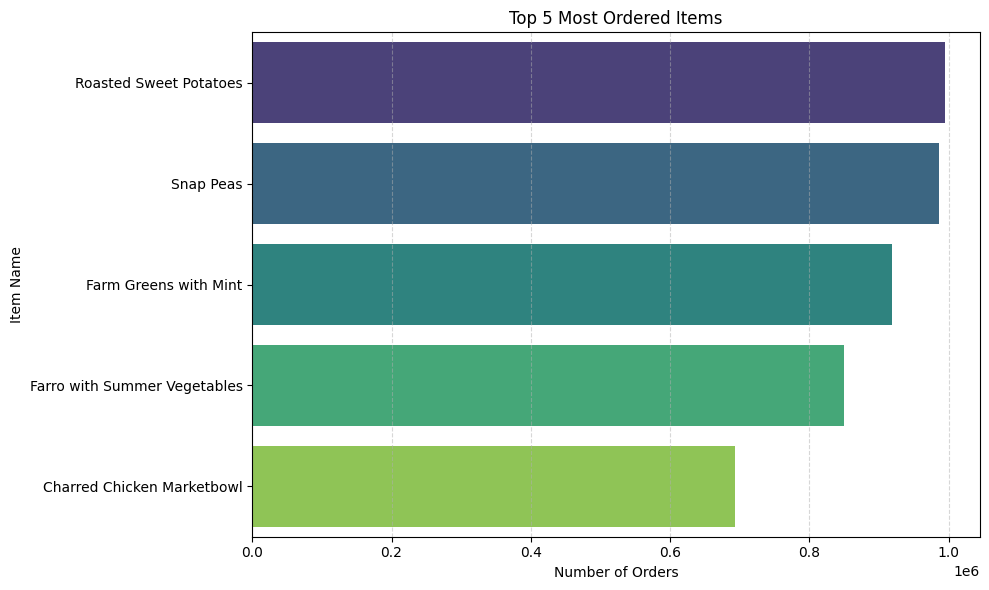

In [ ]:
# PURPOSE:
# This chart visually presents the insights derived from the previous code query.

import matplotlib.pyplot as plt
# Plot using hue to avoid future deprecation
plt.figure(figsize=(10, 6))
sns.barplot(
    x='COUNT',
    y='ITEM_NAME',
    hue='ITEM_NAME',          # Assign y-axis to hue
    data=top_items,
    palette='viridis',
    legend=False              # Turn off redundant legend
)

plt.title('Top 5 Most Ordered Items')
plt.xlabel('Number of Orders')
plt.ylabel('Item Name')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('top_5_items_barh.png', dpi=300)
plt.show()

# FINDINGS:
# The most ordered item overall is **Roasted Sweet Potatoes**, followed by **Snap Peas**,
# **Farm Greens with Mint**, **Farro with Summer Vegetables**, and the **Herb Roasted Chicken Marketbowl**.
# These insights help determine which menu items are driving customer preferences,
# and they can be used for menu planning, inventory decisions, or promotional campaigns.

# Code structure and plotting logic adapted with assistance from an AI language model (OpenAI, 2023).

# Section 4 – Strategic Recommendations

## Problem Statement

The restaurant faces three intertwined operational challenges that affect sales performance and resource utilization:

- There is a significant drop in order volume during non-peak hours, particularly between **2:00 PM and 5:00 PM**, leaving staff underutilized and limiting kitchen efficiency.
- Several menu items consistently underperform despite being on the menu, contributing little to revenue while occupying inventory space.
- The **delivery channel underperforms** compared to in-store and pickup orders, missing opportunities to reach digital-first consumers.

These issues are especially pronounced in **July**, which records the **lowest monthly order volume** across all order types, signaling an urgent need for targeted action.

## Recommendations

### 1. Launch a **Monthly Meal Pass** to Activate July and Non-Peak Demand  
*Refer to: Order Volume by Hour and Day of Week & Menu Items Ordered by Time Slot and Order Type*

**Initiative:**  
Introduce a prepaid **Monthly Meal Pass** that encourages customer visits during off-peak hours by offering value-packed meals from 2:00 PM to 5:00 PM. The pass would feature under-ordered menu items to drive exposure and create steady foot traffic during typically slow periods.

**Action Steps:**
- Offer passes valid for **8 to 12 meals per month**, redeemable only on weekdays during 2–5 PM  
- Bundle meals with **least-ordered items** such as side dishes or low-performing mains  
- Highlight value by combining a **main + drink or side**, changing the menu monthly to keep interest high  
- Promote through email campaigns, in-store signage, and app notifications

**Benefits:**
- Smooths kitchen activity throughout the day  
- Converts sporadic visits into **predictable, recurring revenue**  
- Increases **visibility and trial** of low-performing items while boosting customer engagement during July

*Recent industry research indicates that 81% of Gen Z adults and 79% of millennials are likely to participate in a meal subscription program if offered, highlighting the potential of such initiatives to generate recurring revenue and enhance customer loyalty (National Restaurant Association, 2024).*

---

### 2. Rebrand and Reposition Underperforming Menu Items  
*Refer to: Bottom 10 Least Ordered Items Overall, Top 5 Most Ordered Items, and Top 5 Mains by Order Type*

**Initiative:**  
Apply behavioral insights and menu psychology to refresh the presentation, naming, and placement of chronically underperforming items. Leverage visual design and product bundling to improve visibility and boost sales.

**Action Steps:**
- **Rebrand items** like “Roasted Wild Alaskan Salmon Marketbowl” with more emotionally engaging names (e.g., *Aurora Glazed Salmon Medley*)  
- Move these dishes into **high-visibility menu positions** (e.g., top-right quadrant of the menu or app banners)  
- Bundle low-performing items with bestsellers such as Roasted Sweet Potatoes to drive volume  
- Launch a **“Snack-Time Refresh” campaign** pairing cookies or low-selling sides with premium drinks during afternoon hours  
- Introduce **Limited-Time Offers (LTOs)** to create scarcity and urgency around updated dishes  

*Inspired by neuromarketing strategies used in the fast-food industry, such as those applied by McDonald’s to reshape customer perception through visual psychology and strategic item placement (Battye, 2022).*

**Benefits:**
- **Increases perceived value** of low-selling items  
- Encourages **experimentation** and new trials  
- Drives incremental sales through **strategic bundling and placement**  
- Enhances menu appeal without introducing new SKUs

*Research shows that renaming food items using sensory or cultural cues can increase selection rates by up to 27% (Turnwald et al., 2019).*

---

### 3. Drive Online Delivery Growth Through Targeted Digital Incentives  
*Refer to: Menu Items Ordered by Time Slot and Order Type*

**Initiative:**  
Elevate the delivery experience to match the convenience expectations of modern consumers by incentivizing online behavior through loyalty rewards, dynamic promotions, and real-time personalization.

**Action Steps:**
- Launch a **delivery-specific loyalty program**, awarding points for every order placed online or through the app  
- Use **geo-targeted promotions**: push lunchtime pickup offers to office zones, and dinner delivery deals to residential areas within a 500-meter radius  
- Create **AI-driven bundles** that match popular items with underperformers and label them as “Recommended for You” or “Customer Favorites”  
- Highlight these dynamic pairings at checkout or on delivery apps to guide ordering behavior

**Benefits:**
- Boosts **digital conversion and average order value**  
- Taps into the growing demand for **delivery convenience**  
- Helps **reallocate inventory** by pairing high- and low-performing items  
- Builds long-term **customer loyalty** and strengthens the brand’s presence in digital channels

*Recent research emphasizes that well-designed digital loyalty programs play a critical role in deepening brand connection and increasing customer retention, particularly in competitive markets (Obe, 2025).*

---

# References

* Battye, L. (2022, February 17). *Why we’re loving it: The psychology behind the McDonald’s restaurant of the future*. BehavioralEconomics.com | The BE Hub. https://www.behavioraleconomics.com/loving-psychology-behind-mcdonalds-restaurant-future/

* Google. (2024). *Colab code generator [AI-powered tool]*. Google Colaboratory. https://colab.research.google.com/

* National Restaurant Association. (2024). Reap recurring revenue with subscription plans. https://restaurant.org/education-and-resources/resource-library/reap-recurring-revenue-with-subscription-plans/

* Obe, E. (2025). *Building customer loyalty in the digital age*. Carmignac. https://www.carmignac.com/en-fr/markets-and-outlook/flash-note/building-customer-loyalty-in-the-digital-age-11455

* OpenAI. (2023). *ChatGPT (GPT-4o) [Large language model]*. https://chat.openai.com

* Turnwald, B. P., Boles, D. Z., & Crum, A. J. (2019). Association between indulgent descriptions and vegetable consumption: Twisted carrots and dynamite beets. *JAMA Internal Medicine, 179*(4), 528–529. https://pmc.ncbi.nlm.nih.gov/articles/PMC5818791/


# Appendices

## Average Number of Cookies per Order per Month

Average number of cookies per order: 0.26


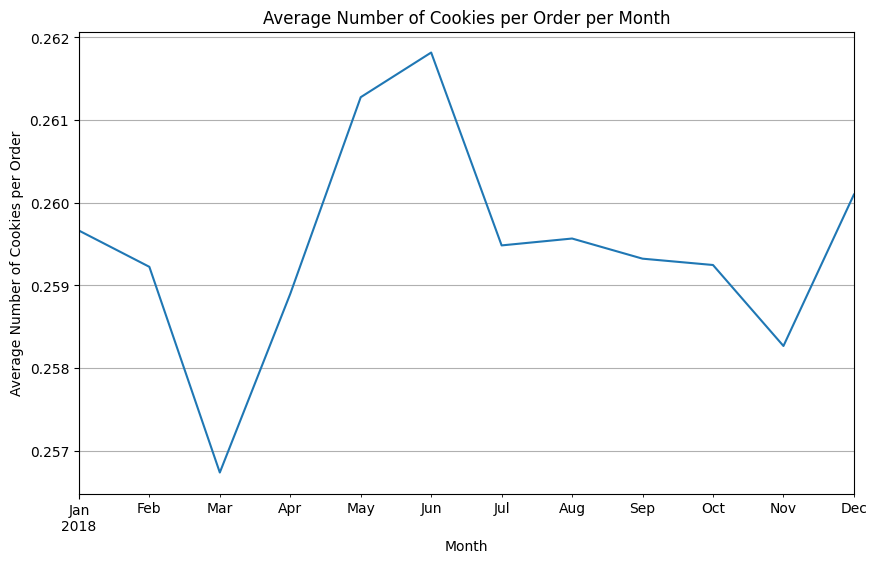

In [ ]:
# PURPOSE:
# This query analyzes how the average number of cookies ordered per customer varies over time.
# It calculates monthly averages using resampling and plots these to reveal seasonal patterns.
# This analysis helps understand customer behavior around cookie purchases, and whether specific months
# see spikes or declines that could be linked to seasonal preferences or promotions.

import pandas as pd
import matplotlib.pyplot as plt

orders_7_df['COOKIES'] = pd.to_numeric(orders_7_df['COOKIES'], errors='coerce')

# Calculate the average number of cookies per order
average_cookies_per_order = orders_7_df['COOKIES'].mean()
print(f"Average number of cookies per order: {average_cookies_per_order:.2f}")

# Group by restaurant and calculate the average number of cookies
average_cookies_by_restaurant = orders_7_df.groupby('RESTAURANT_NAME')['COOKIES'].mean()

# Calculate the average number of cookies per month
# Ensure 'DATETIME' is a datetime object (done in the setup section)
average_cookies_monthly = orders_7_df.set_index('DATETIME').resample('ME')['COOKIES'].mean()

# Plot the average number of cookies per month
plt.figure(figsize=(10, 6))
average_cookies_monthly.plot(kind='line')
plt.title('Average Number of Cookies per Order per Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Cookies per Order')
plt.grid(True)
plt.show()

# FINDINGS:
# The average number of cookies per order remained relatively consistent throughout the year,
# fluctuating within a narrow range (~0.257 to ~0.262). However, a noticeable increase is observed
# during late spring and early summer (May–June), suggesting a slight seasonal uplift in cookie interest.
# Conversely, a small dip occurs in March and again in November, which may correspond to colder periods,
# competing product promotions, or overall order composition changes.
# Though these shifts are minor, they may still inform inventory planning or seasonal product pairings.

# Code structure and analysis adapted with assistance from an AI language model (OpenAI, 2023).

## Most Ordered Items per Time Block

In [ ]:
# PURPOSE:
# This code compares the top 3 most ordered menu items across different
# time blocks (Morning, Lunch, Afternoon, Dinner, Late). Each bar represents the number
# of times a specific item was ordered during a given time block, allowing us to
# identify item popularity patterns throughout the day.

import pandas as pd

# Use the merged_orders DataFrame which already has item names merged
combo_cols_with_names = ['MAIN_NAME_x', 'BASE_NAME_x', 'SIDE_1_NAME_x', 'SIDE_2_NAME_x']

# Extract hour and assign time blocks
merged_orders['HOUR'] = merged_orders['DATETIME'].dt.hour
merged_orders['TIME_BLOCK'] = pd.cut(
    merged_orders['HOUR'],
    bins=[0, 10, 14, 17, 21, 24],
    labels=['Morning', 'Lunch', 'Afternoon', 'Dinner', 'Late']
)

# Melt item columns into one and drop missing
melted = merged_orders.melt(
    id_vars='TIME_BLOCK',
    value_vars=combo_cols_with_names,
    value_name='ITEM_NAME'
).dropna()

# Group and count
time_popular = (
    melted.groupby(['TIME_BLOCK', 'ITEM_NAME'], observed=True)
    .size()
    .reset_index(name='COUNT')
)

# Sort and select top 3 per time block, again with observed=True
top_per_time = (
    time_popular
    .sort_values(['TIME_BLOCK', 'COUNT'], ascending=[True, False])
    .groupby('TIME_BLOCK', observed=True)
    .head(3)
)

# Display result
print("Top 3 Items per Time Block:")
display(top_per_time)

# Code structure and visualization logic adapted with assistance from an AI language model (OpenAI, 2023).

Top 3 Items per Time Block:


,TIME_BLOCK,ITEM_NAME,COUNT
12,Morning,Roasted Sweet Potatoes,16201
14,Morning,Snap Peas,16094
6,Morning,Farm Greens with Mint,14843
28,Lunch,Roasted Sweet Potatoes,422961
30,Lunch,Snap Peas,419729
22,Lunch,Farm Greens with Mint,391174
44,Afternoon,Roasted Sweet Potatoes,224939
46,Afternoon,Snap Peas,222631
38,Afternoon,Farm Greens with Mint,206669
60,Dinner,Roasted Sweet Potatoes,294796


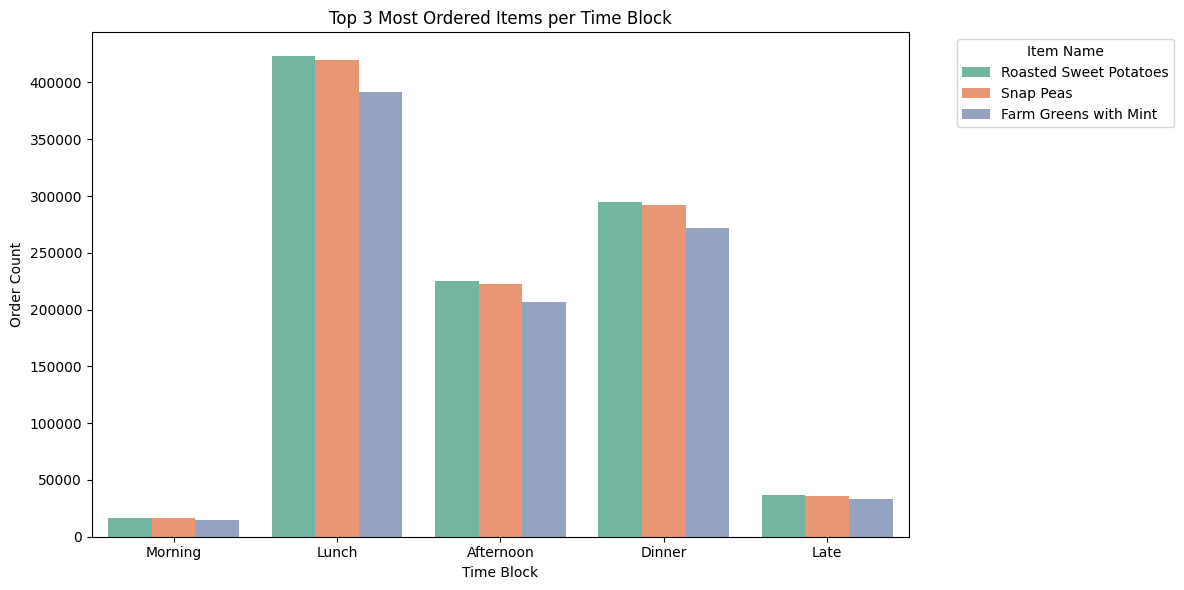

In [ ]:
# PURPOSE:
# This chart visually presents the insights derived from the previous code query.

import matplotlib.pyplot as plt
import seaborn as sns

# Sort time blocks in correct order
time_order = ['Morning', 'Lunch', 'Afternoon', 'Dinner', 'Late']
top_per_time['TIME_BLOCK'] = pd.Categorical(top_per_time['TIME_BLOCK'], categories=time_order, ordered=True)

# Set figure size and style
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_per_time,
    x='TIME_BLOCK',
    y='COUNT',
    hue='ITEM_NAME',
    palette='Set2'
)

plt.title('Top 3 Most Ordered Items per Time Block')
plt.xlabel('Time Block')
plt.ylabel('Order Count')
plt.legend(title='Item Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# FINDINGS:
# Across all time blocks, three items consistently dominate:
# 1. Roasted Sweet Potatoes
# 2. Snap Peas
# 3. Farm Greens with Mint
#
# These three items are the top performers in **every time segment**, showing remarkable consistency.
# - During **Lunch**, they reach their peak, with Roasted Sweet Potatoes ordered over 422,000 times.
# - **Afternoon** and **Dinner** time blocks follow similar patterns, though with slightly lower volume.
# - Even during the **Late** time block (after 9 PM), these items maintain their lead.
# This suggests strong all-day appeal and provides strong candidates for core menu or combo promotions.

# Code and visual formatting generated with support from an AI language model (OpenAI, 2023).

## Order Volume of Key Menu Items by Season

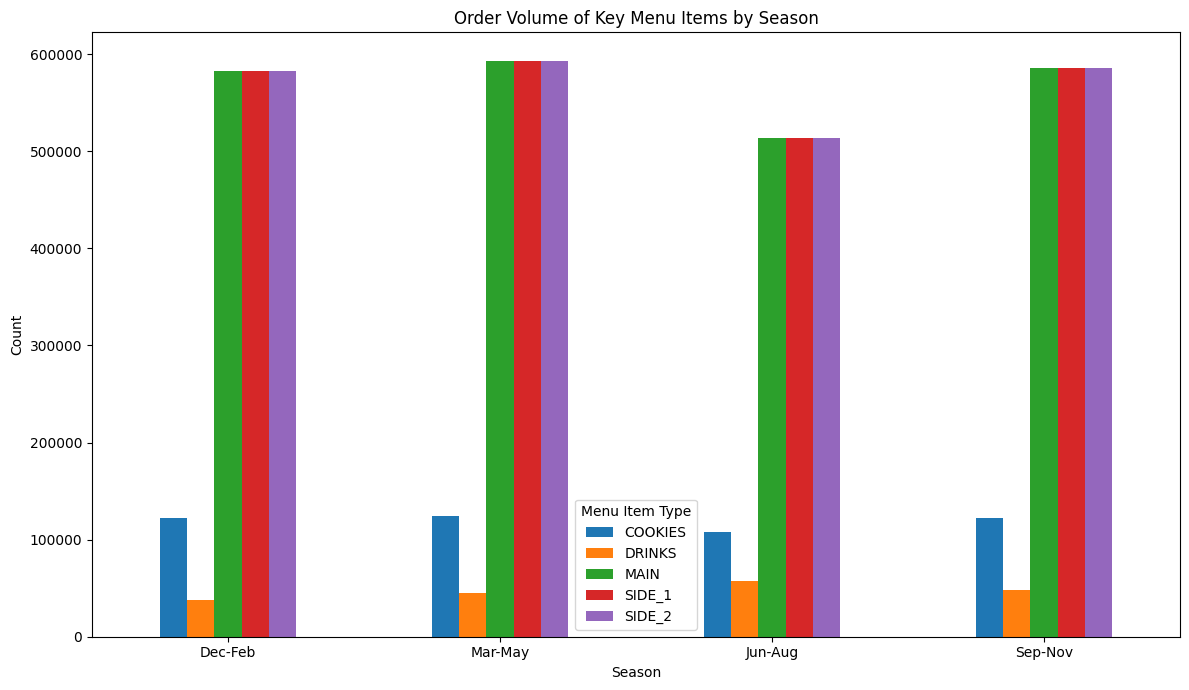

In [ ]:
# PURPOSE:
# This query analyzes the distribution of key menu item types (DRINKS, COOKIES, MAIN, SIDE_1, SIDE_2)
# across different seasons. It helps identify seasonal consumption patterns and can support
# inventory, staffing, and marketing strategies throughout the year.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure DATETIME column is in datetime format
if not pd.api.types.is_datetime64_any_dtype(orders_7_df['DATETIME']):
    df_orders_7['DATETIME'] = pd.to_datetime(orders_7_df['DATETIME'])

# Function to categorize months into seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Dec-Feb'
    elif month in [3, 4, 5]:
        return 'Mar-May'
    elif month in [6, 7, 8]:
        return 'Jun-Aug'
    elif month in [9, 10, 11]:
        return 'Sep-Nov'
    else:
        return 'Other'

# Apply season classification
orders_7_df['Season'] = orders_7_df['DATETIME'].dt.month.apply(get_season)

# Define column groups
numeric_columns = ['DRINKS', 'COOKIES']
text_columns = ['MAIN', 'SIDE_1', 'SIDE_2']

# Initialize list to collect counts
result_data = []

# Count numeric items per season
for column in numeric_columns:
    season_counts = orders_7_df[orders_7_df[column] > 0].groupby('Season').size()
    for season, count in season_counts.items():
        result_data.append({'Season': season, 'ItemType': column, 'Count': count})

# Count text-based item categories per season
for column in text_columns:
    filtered_df = orders_7_df[orders_7_df[column].replace(['NaN', 'nan'], np.nan).notnull()]
    season_counts = filtered_df.groupby('Season').size()
    for season, count in season_counts.items():
        result_data.append({'Season': season, 'ItemType': column, 'Count': count})

# Create and pivot dataframe
df_season_item_counts = pd.DataFrame(result_data)
df_pivot_season = df_season_item_counts.pivot_table(
    index='Season',
    columns='ItemType',
    values='Count',
    fill_value=0
)

# Reorder seasons chronologically
season_order = ['Dec-Feb', 'Mar-May', 'Jun-Aug', 'Sep-Nov']
df_pivot_season = df_pivot_season.reindex(season_order, fill_value=0)

# Plot bar chart
df_pivot_season.plot(kind='bar', figsize=(12, 7), stacked=False)
plt.title('Order Volume of Key Menu Items by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Menu Item Type')
plt.tight_layout()
plt.show()

# FINDINGS:
# The chart reveals relatively stable patterns for the most ordered item types across seasons,
# with only mild fluctuations. MAIN, SIDE_1, and SIDE_2 items maintain consistently high volumes year-round.
# However, COOKIES and DRINKS show more pronounced seasonal variation:
# - DRINK orders increase in the summer (Jun–Aug), possibly due to higher temperatures or promotional tie-ins.
# - COOKIE orders drop in summer but spike again in Sep–Nov, which may relate to cooler weather or fall promotions.
# These seasonal insights support planning for item-specific promotions, prep volume, and inventory adjustments.

# Code structure and analysis adapted with assistance from an AI language model (OpenAI, 2023).

## Percentage of Menu Items by Time Slot and Order Type

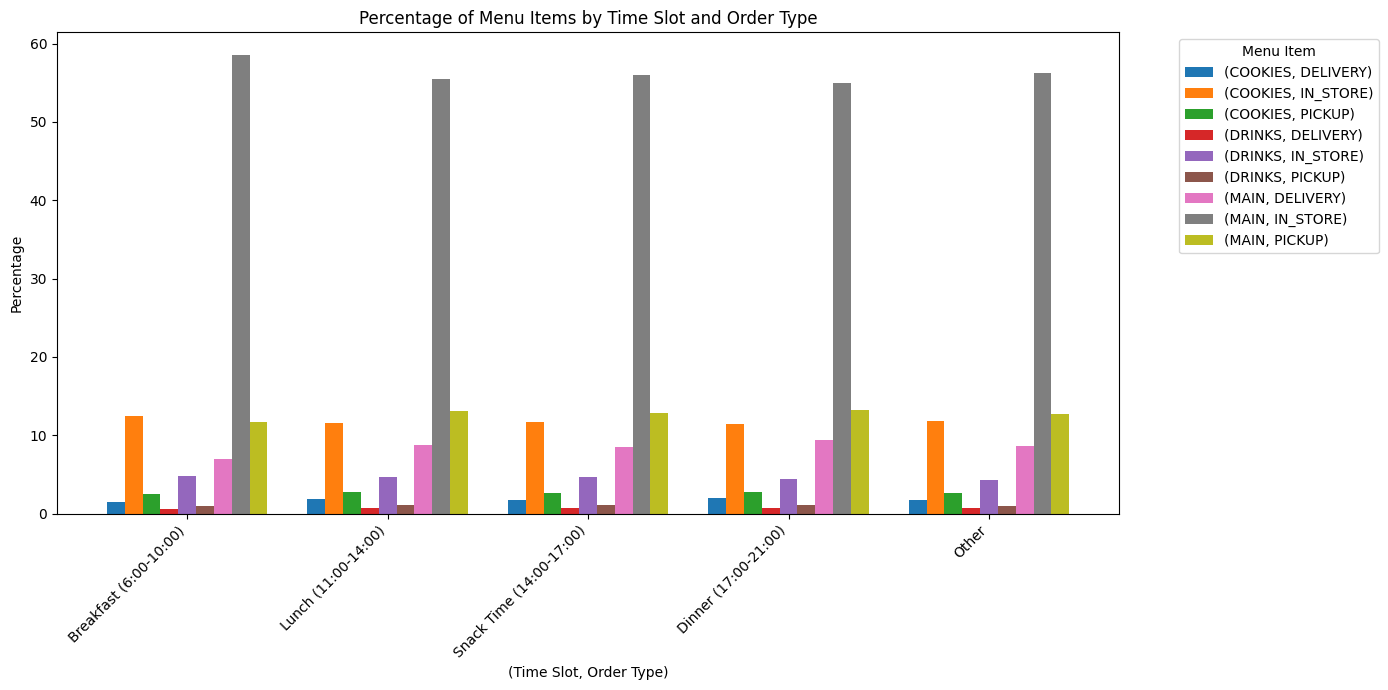

In [ ]:
# PURPOSE:
# This code visualizes the relative composition of menu items (DRINKS, COOKIES, MAIN)
# across different order types (DELIVERY, IN_STORE, PICKUP) and time slots
# (e.g., Breakfast, Lunch, Dinner). Rather than displaying raw counts,
# it calculates the percentage share of each item category within each time slot,
# allowing for more meaningful comparisons regardless of total volume.

# Calculate total orders per time slot
df_time_slot_totals = df_pivot_time.drop(('Total', '')).groupby(level='Time Slot').sum()

# Calculate percentages for each (Time Slot, Order Type) row
df_percentage_by_time_slot = df_pivot_time.drop(('Total', '')).apply(
    lambda row: row / df_time_slot_totals.loc[row.name[0]].sum() * 100,
    axis=1
)

df_percentage_by_time_slot.unstack().plot(kind='bar', figsize=(14, 7), width=0.8)
plt.title('Percentage of Menu Items by Time Slot and Order Type')
plt.xlabel('(Time Slot, Order Type)')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Menu Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# FINDINGS:
# The percentage distribution shows that MAIN items consistently dominate across all time slots,
# particularly in the IN_STORE channel, where they account for over 55% of total item volume.
# IN_STORE orders also show a noticeable share of COOKIES and DRINKS during Breakfast and Lunch.
# PICKUP orders have a slightly more balanced spread across COOKIES and MAINS, especially in the afternoon.
# DELIVERY remains low across all time slots and item categories, reinforcing previous observations
# that most engagement with the full menu occurs in-store.
# This breakdown helps identify when and how customers diversify their purchases and may inform
# targeted promotions (e.g., pairing drinks with mains in the morning or cookie combos in the afternoon).

# Code structure and visualization logic adapted with assistance from an AI language model (OpenAI, 2023).

## Preferred Menu Items by Order Type

          DRINKS  COOKIES     MAIN     BASE   SIDE_1   SIDE_2    TOTAL
TYPE                                                                  
DELIVERY   21931    54635   259972   259972   259972   259972  1116454
IN_STORE  133947   342048  1632799  1632799  1632799  1632799  7007191
PICKUP     31518    79824   382868   382868   382868   382868  1642814


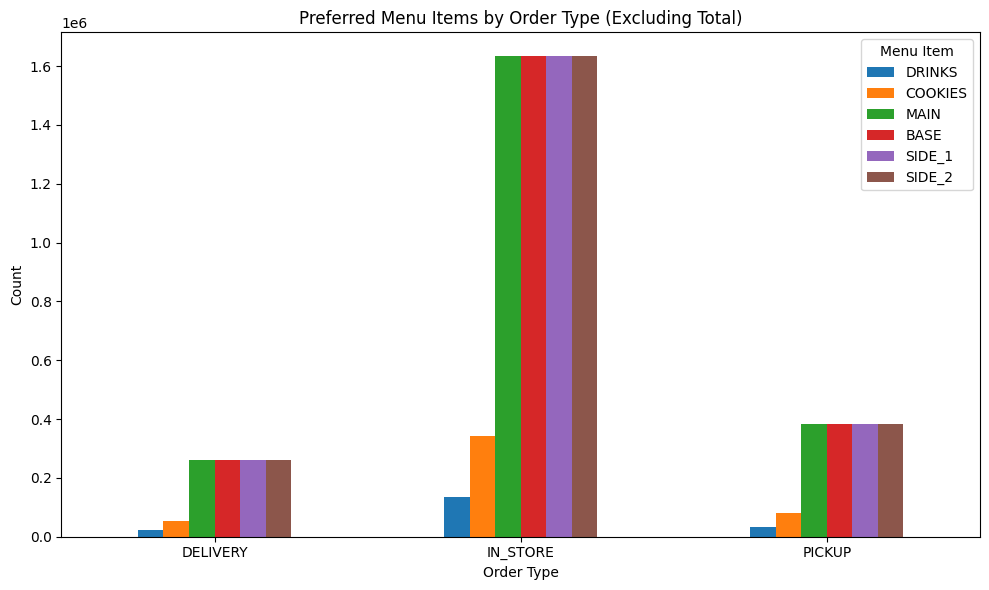

In [ ]:
# PURPOSE:
# This query compares the total counts of menu item types (e.g., DRINKS, COOKIES, MAINS, etc.)
# across different order types (DELIVERY, IN_STORE, PICKUP).
# It counts how often each item type appears in each order type category,
# helping to reveal preferences in customer ordering behavior by channel.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define custom function to count non-NaN entries in categorical columns
def count_non_nan(series):
    return series.replace(['NaN', 'nan'], np.nan).notnull().sum()

# Group by order type and aggregate each item category
result = orders_7_df.groupby('TYPE').agg({
    'DRINKS': lambda x: (x > 0).sum(),
    'COOKIES': lambda x: (x > 0).sum(),
    'MAIN': count_non_nan,
    'BASE': count_non_nan,
    'SIDE_1': count_non_nan,
    'SIDE_2': count_non_nan
})

# Add total for reference (not used in plot)
result['TOTAL'] = result.sum(axis=1)

# Print table for validation
print(result)

# Prepare for plot by removing 'TOTAL'
result_for_plot = result.drop('TOTAL', axis=1)

# Plotting
result_for_plot.plot(kind='bar', figsize=(10, 6))
plt.title('Preferred Menu Items by Order Type (Excluding Total)')
plt.xlabel('Order Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Menu Item')
plt.tight_layout()
plt.show()

# FINDINGS:
# The data clearly shows that IN_STORE orders dominate in volume across all menu item types,
# particularly for MAIN, BASE, and SIDE items. DELIVERY and PICKUP orders trail far behind,
# although the relative proportions of item categories remain consistent.
# DRINKS and COOKIES have the lowest overall volume but still exhibit the same channel preference pattern.
# This pattern confirms that most customers are engaging with the full menu in person,
# which reinforces the importance of optimizing the in-store experience, layout, and staffing.

# Code structure and visualization logic adapted with assistance from an AI language model (OpenAI, 2023).

## Seasonal Trends in Average Drink Orders per Week

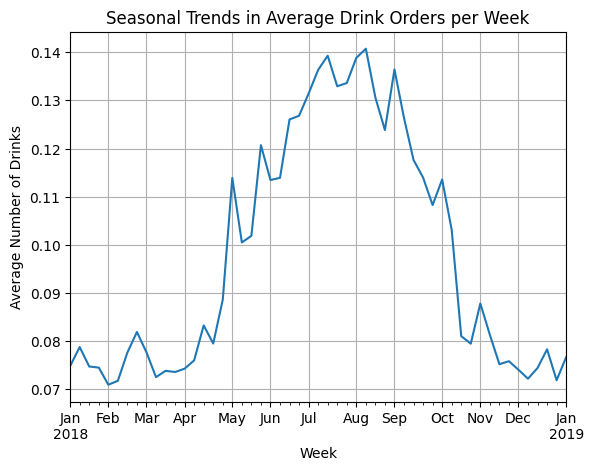

In [ ]:
# PURPOSE:
# This query analyzes the average number of drinks sold per order on a weekly basis.
# It helps identify seasonal or time-based patterns in drink purchasing behavior.
# The data is resampled by week, averaged, and visualized using a line chart.

# Resample by week and plot the mean of drinks
(
    orders_7_df.set_index('DATETIME')   # Set DATETIME as the index
    .resample('W')                    # Weekly resampling
    .DRINKS                           # Select the DRINKS column
    .mean()                           # Compute weekly average
    .plot()
)

plt.title('Seasonal Trends in Average Drink Orders per Week')
plt.xlabel('Week')
plt.ylabel('Average Number of Drinks')
plt.grid(True)
plt.show()

# FINDINGS:
# The trend shows a clear seasonal spike in drink sales between late spring and early fall,
# with peak averages occurring from May through September. This suggests higher demand for drinks
# during warmer months, potentially driven by increased foot traffic, higher temperatures, or seasonal promotions.
# In contrast, the colder months (especially January to April and October to December)
# show a notably lower average number of drinks sold per order.
# This pattern supports the use of summer-specific drink offerings and
# inventory planning aligned with weather-based fluctuations.

# Code structure and logic adapted with assistance from an AI language model (OpenAI, 2023).

## Top 5 Item Combinations

Top 5 Item Combinations:


,MAIN_NAME_x,BASE_NAME_x,SIDE_1_NAME_x,SIDE_2_NAME_x,COUNT
0,Spicy Meatballs Marketbowl,Farm Greens with Mint,Snap Peas,Snap Peas,39492
1,Spicy Meatballs Marketbowl,Farro with Summer Vegetables,Snap Peas,Snap Peas,31467
2,Herb Roasted Chicken Marketbowl,Farm Greens with Mint,Roasted Sweet Potatoes,Roasted Sweet Potatoes,31191
3,Herb Roasted Chicken Marketbowl,Farro with Summer Vegetables,Cauliflower with Garlic and Parmesan,Cauliflower with Garlic and Parmesan,26745
4,Herb Roasted Chicken Marketbowl,Farro with Summer Vegetables,Roasted Sweet Potatoes,Cauliflower with Garlic and Parmesan,21831


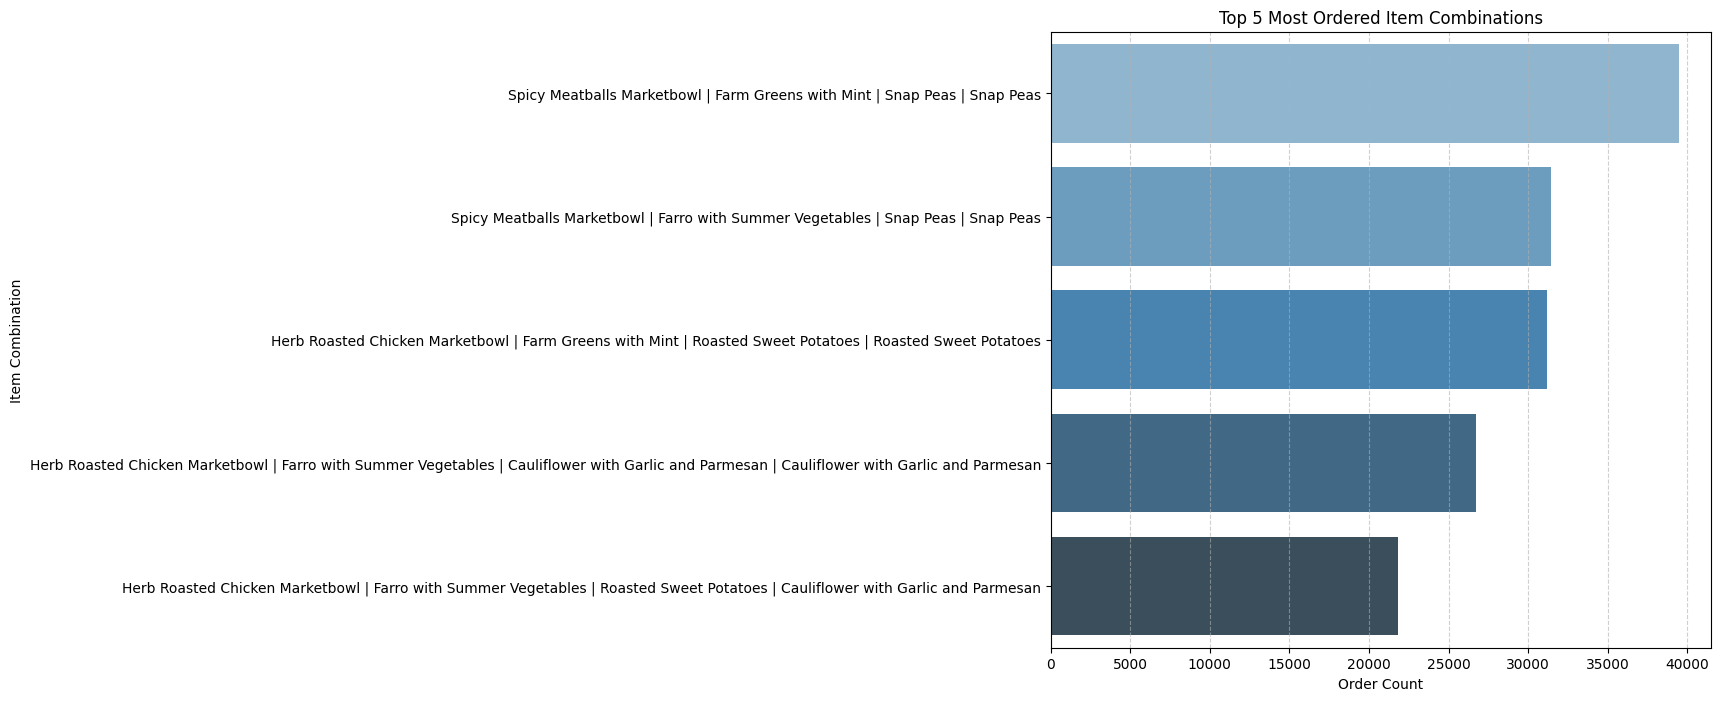

In [ ]:
# PURPOSE:
# This query identifies the top 5 most frequently ordered item combinations across all restaurants.
# It examines the combination of MAIN, BASE, SIDE_1, and SIDE_2 names and ranks them by frequency.

# Combo columns based on actual merged column names
combo_cols = ['MAIN_NAME_x', 'BASE_NAME_x', 'SIDE_1_NAME_x', 'SIDE_2_NAME_x']

# Drop rows with missing item components and count combinations
top_combos = (
    merged_orders[combo_cols]
    .dropna()
    .value_counts()
    .head(5)
    .reset_index(name='COUNT'))

# Display result
print("Top 5 Item Combinations:")
display(top_combos)

# Visualize
# Create label column by joining item names
top_combos['COMBO_LABEL'] = top_combos[combo_cols].agg(' | '.join, axis=1)

# Plot
plt.figure(figsize=(12, 8))  # Increased width and height
sns.barplot(
    x='COUNT',
    y='COMBO_LABEL',
    hue='COMBO_LABEL',           # Required to apply the palette in future Seaborn versions
    data=top_combos,
    palette='Blues_d',
    legend=False                 # Hides redundant color legend
)

plt.title('Top 5 Most Ordered Item Combinations')
plt.xlabel('Order Count')
plt.ylabel('Item Combination')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.subplots_adjust(left=0.35)  # Add more left margin for long labels
plt.show()

# FINDINGS:
# The top 5 most frequently ordered item combinations reveal clear customer preferences,
# with two combinations featuring the "Spicy Meatballs Marketbowl" and three featuring
# the "Herb Roasted Chicken Marketbowl" as the MAIN component.
# Notably, "Snap Peas" and "Roasted Sweet Potatoes" appear repeatedly across combinations,
# either as SIDE_1 or SIDE_2, suggesting these sides are strong complements to the top mains.
# The most popular combo overall includes Spicy Meatballs with Farm Greens and a double serving of Snap Peas.
# These patterns offer valuable input for bundled menu planning, upsell strategies,
# and inventory optimization, especially around these high-frequency components.

# Code structure and insights adapted with assistance from an AI language model (OpenAI, 2023).